### Doku:

1) https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid-tiramisu.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient

In [5]:
from fastai.callbacks.hooks import  params_size
def extract_train_information(learner: Learner):
    _, params, trainables, _ = params_size(learner.model)

    total_params = sum(params)
    trainable_ratio = sum([param*train for param, train in zip(params, trainables)]) / total_params * 100

    bs = learner.data.batch_size
    image_size = learner.data.valid_ds[0][0].size
    wd = learner.wd
    lr = max(learner.recorder.lrs)

    summary = "\nTotal params: {:,}".format(total_params)
    summary += f"\nTrainable: {round(trainable_ratio,2)}%"
    summary += f"\nBs: {bs}"
    summary += f"\nwd: {wd}"
    summary += f"\nlr: {lr}"
    summary += f"\nImage: {image_size}\n"

    for tf in learner.data.train_dl.dl.dataset.tfms:
        summary += f"\n {tf}"
    
    return summary

In [6]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [7]:
np.random.seed(42)

In [8]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [9]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

In [10]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

In [11]:
split_handler = SplitByPatient(hem_patients, all_patints)

In [12]:
train_regex = re.compile(r'(fold_0|fold_1)')
val_regex = re.compile(r'(fold_2)')

hem_train, all_train, hem_val, all_val = split_handler.split_by_regex(train_regex, val_regex)

In [13]:
pat = re.compile(r'^.*(hem|all).bmp$')

In [14]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn):
        image = np.asarray(PIL.Image.open(fn).convert("RGB"))

        mask = np.zeros(shape=(image.shape[0], image.shape[1]), dtype=np.uint8)
        image = np.max(image, axis=2)

        if pat.search(str(fn)).group(1) == "hem":
            mask[image > 0] = 1
        else:
            mask[image > 0] = 2
        mask = np.expand_dims(mask, axis=0)
        return ImageSegment(FloatTensor(mask))

class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [15]:
valid = SegItemListCustom(hem_val+all_val)
train = SegItemListCustom(hem_train+all_train)

In [16]:
data = (ItemLists(path, train, valid)
        .label_from_func(lambda x: x, classes=['Bg', 'hem', 'ALL'])
        .transform(get_transforms(), size=256, tfm_y=True)
        .databunch(bs=32)
        .normalize())

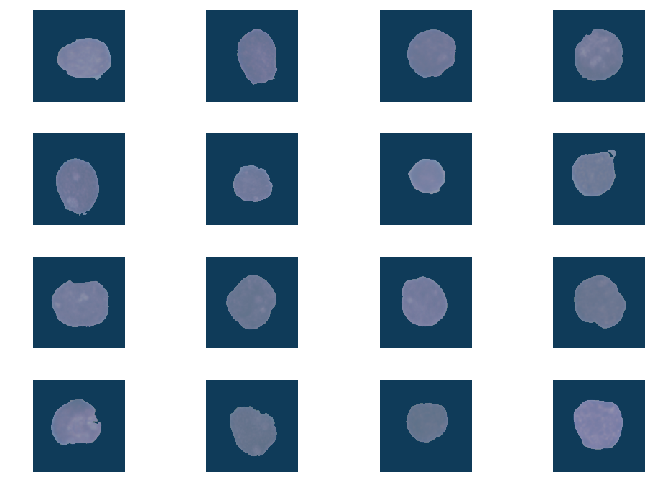

In [17]:
data.show_batch(4, figsize=(10,7))

In [29]:
def acc_cell_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [30]:
from fastai.callbacks import *
from sklearn.metrics import f1_score

class F1WeightedCell(Callback):

    def on_epoch_begin(self, **kwargs):
        self.y_true, self.y_pred = [], []

    def on_batch_end(self, last_output, last_target, **kwargs):
        target = last_target.data.cpu().numpy()
        input = last_output.data.cpu().numpy()

        target = np.squeeze(target, axis=1)
        mask = target != 0

        y_pred = []
        y_true = []

        input = np.argmax(input, axis=1)
        for i in range(input.shape[0]):
            input_mask = input[i][mask[i]]
            target_mask = target[i][mask[i]]

            counts_input = np.bincount(input_mask)
            class_input = np.argmax(counts_input)
            y_pred.append(class_input)

            counts_target = np.bincount(target_mask)
            class_target = np.argmax(counts_target)
            y_true.append(class_target)
            
            
        self.y_pred.extend(y_pred)
        self.y_true.extend(y_true)

    def on_epoch_end(self, **kwargs):
        self.metric = f1_score(self.y_true, self.y_pred, average='weighted')

In [31]:
learn = unet_learner(data, models.resnet34, metrics=[acc_cell_pixel, F1WeightedCell()], callback_fns=[ShowGraph])

epoch,train_loss,valid_loss,acc_cell_pixel,f1_weighted_cell
1,0.093889,0.092633,0.739745,0.713748
2,0.263995,0.098482,0.736265,0.743600
3,0.072353,0.089842,0.773925,0.774768
4,0.063379,0.078509,0.789717,0.790171
5,0.057396,0.081136,0.786729,0.790360


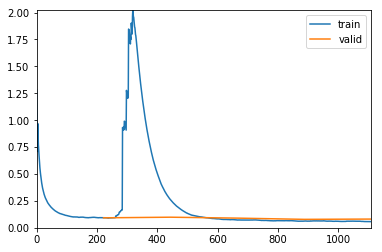

In [32]:
learn.fit_one_cycle(5)

In [33]:
learn.unfreeze()

epoch,train_loss,valid_loss,acc_cell_pixel,f1_weighted_cell
1,0.064901,0.087624,0.765412,0.780750
2,0.086464,0.094782,0.696865,0.574649
3,0.071390,0.078015,0.782308,0.787959
4,0.063859,0.078886,0.786432,0.797399
5,0.059004,0.079290,0.784427,0.793428


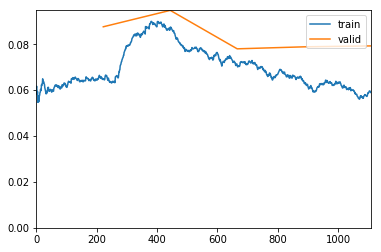

/home/c.marzahl@de.eu.local/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
learn.fit_one_cycle(5)